<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os, random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [3]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 80000

MAXIMO_MODELOS = 20

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 32
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

NEURONIOS_DENSO = 128
ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [5]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [7]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [8]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [9]:
X = dados['preprocessed_news']
y = dados['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760,), (1440,), (5760,), (1440,))

In [11]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('O'), dtype('O'), dtype('int64'), dtype('int64'))

### Converter texto em números

In [12]:
# media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

# tamanho_texto = media_palavras_por_texto
tamanho_texto = maximo_palavras_por_texto

#### Vetorização (Vectorization)

In [13]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

frentes bolsonaro jean wyllys presidenciavel assinou criacao grupos camara deputados defesa futsal participa tres psol base discurso visivel deputado presidenciavel jair bolsonaro questoes seguranca publica ordem moral ate ai nenhuma novidade claro so seguranca religiao vive parlamentar pesquisa site propria camara frentes parlamentares funcionamento revela bolsonaro digamos assim diversificado praticamente todos deputados bolsonaro assinou criacao serie frentes inusitadas estao defesa futsal defesa valorizacao nacional uvas vinhos espumantes derivados odontologia brasil jogos azar ha ate frente temas estado pauta deputados esquerda ligados direitos humanos reforma psiquiatrica luta antimanicomial bolsonaro inscrito tres frentes deputado jean wyllys tambem inscrito frente automobilismo brasileiro frente defesa despachantes documentaristas brasil frente mista artesao artesanato brasileiro assinatura presidenciavel nessas frentes revelam pouca relevancia instrumento frentes parlamentares

<tf.Tensor: shape=(1, 4229), dtype=int64, numpy=array([[4936,  496, 3162, ...,    0,    0,    0]])>

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(73258,
 ['', '[UNK]', 'nao', 'lula', 'ser'],
 ['aapesar', 'aachen', 'aace', 'aabertura', 'aabb'])

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [19]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

souvenir temer comprou china nao funciona inves cachorrinho rosna diz durante visita oficial china presidente michel temer aproveitou folga compras shopping cidade hangzou portal china radio international relatou presidente brasileiro ficou seduzido par sapatos cachorrinho eletronico temer gastou pouco r volta hotel assessores presidente informaram quis testar brinquedinho ligar cachorrinho eis surgiu decepcao pequeno animalzinho nao quis latir presidente rosnou soltou sons parecidos golpe golpe


<tf.Tensor: shape=(1, 4229, 128), dtype=float32, numpy=
array([[[ 0.04004267,  0.04766275, -0.01687266, ..., -0.00147493,
         -0.01140227, -0.01952409],
        [ 0.00277412,  0.01001927,  0.0220607 , ...,  0.04497489,
         -0.0053091 , -0.03067682],
        [ 0.01997003, -0.02834264, -0.02988974, ..., -0.04453854,
         -0.03449243,  0.01225675],
        ...,
        [-0.01864308,  0.02097629,  0.041147  , ..., -0.0424662 ,
          0.00015916, -0.02020692],
        [-0.01864308,  0.02097629,  0.041147  , ..., -0.0424662 ,
          0.00015916, -0.02020692],
        [-0.01864308,  0.02097629,  0.041147  , ..., -0.0424662 ,
          0.00015916, -0.02020692]]], dtype=float32)>

## Funções

In [20]:
def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [21]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [22]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.22      0.36       741
           1       0.55      1.00      0.71       699

    accuracy                           0.60      1440
   macro avg       0.77      0.61      0.53      1440
weighted avg       0.77      0.60      0.53      1440



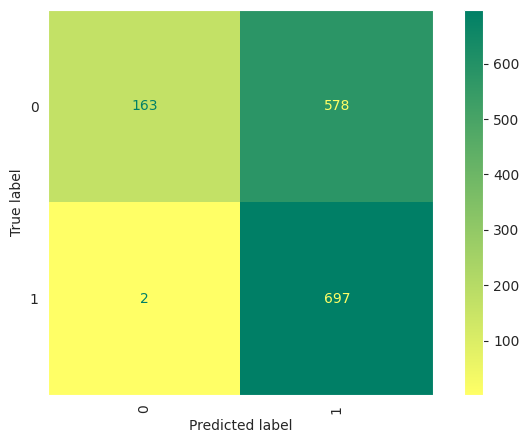

In [24]:
relatorios[modelo_numero] = avaliar_modelo(y_test, previsoes[modelo_numero])

In [25]:
relatorios[modelo_numero]

{'acuracia': 0.5972222222222222,
 'precisao': 0.7737070707070706,
 'revocacao': 0.5972222222222222,
 'pontuacao-f1': 0.5279508332382786}

### Camadas iniciais padronizadas

In [26]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 51.5 ms, sys: 2.52 ms, total: 54.1 ms
Wall time: 99.3 ms


### Modelo 1: Denso

In [27]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 33s 269ms/step - loss: 0.6519 - accuracy: 0.5453 - val_loss: 0.6002 - val_accuracy: 0.7965
Epoch 2/5
90/90 [==============================] - 20s 220ms/step - loss: 0.4994 - accuracy: 0.9259 - val_loss: 0.4166 - val_accuracy: 0.9382
Epoch 3/5
90/90 [==============================] - 21s 228ms/step - loss: 0.3075 - accuracy: 0.9681 - val_loss: 0.2680 - val_accuracy: 0.9500
Epoch 4/5
90/90 [==============================] - 22s 244ms/step - loss: 0.1895 - accuracy: 0.9733 - val_loss: 0.1961 - val_accuracy: 0.9514
Epoch 5/5
90/90 [==============================] - 18s 204ms/step - loss: 0.1309 - accuracy: 0.9786 - val_loss: 0.1614 - val_accuracy: 0.9528
CPU times: user 1min 17s, sys: 1.8 s, total: 1min 18s
Wall time: 2min 24s


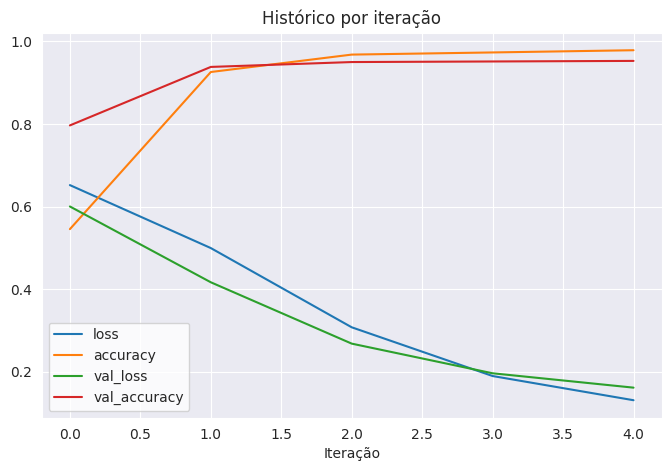

In [28]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       741
           1       0.95      0.95      0.95       699

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



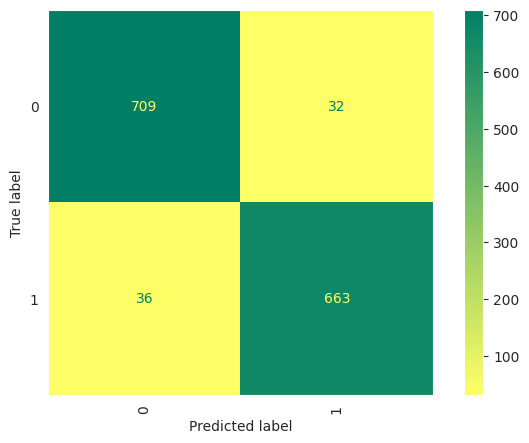

In [29]:
dados_modelo(modelo_numero)

In [30]:
relatorios[modelo_numero]

{'acuracia': 0.9527777777777777,
 'precisao': 0.9527841082838427,
 'revocacao': 0.9527777777777777,
 'pontuacao-f1': 0.9527735832540022}

### Modelo 2: LSTM

In [34]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm'

# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas) # Para empilhar camadas recorrentes é necessário return_sequences=True
camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 33s 327ms/step - loss: 0.6967 - accuracy: 0.4903 - val_loss: 0.6938 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 29s 323ms/step - loss: 0.6938 - accuracy: 0.5031 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 3/5
90/90 [==============================] - 28s 307ms/step - loss: 0.6937 - accuracy: 0.5043 - val_loss: 0.6943 - val_accuracy: 0.4854
Epoch 4/5
90/90 [==============================] - 25s 274ms/step - loss: 0.6934 - accuracy: 0.5102 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 5/5
90/90 [==============================] - 27s 302ms/step - loss: 0.6942 - accuracy: 0.4953 - val_loss: 0.6946 - val_accuracy: 0.4854
CPU times: user 1min 57s, sys: 1.64 s, total: 1min 59s
Wall time: 2min 23s


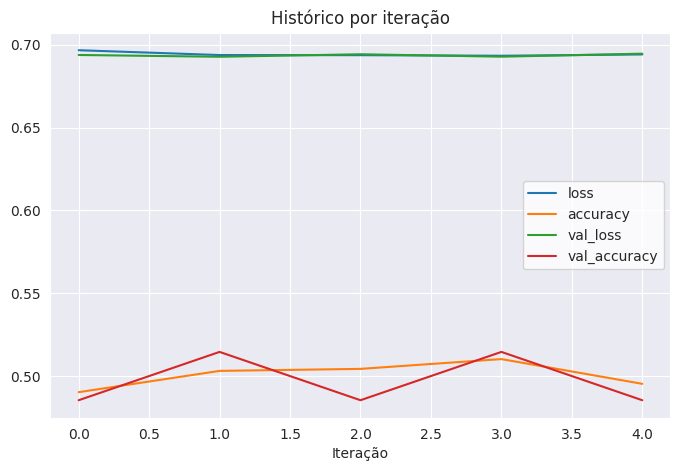

In [35]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 2s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



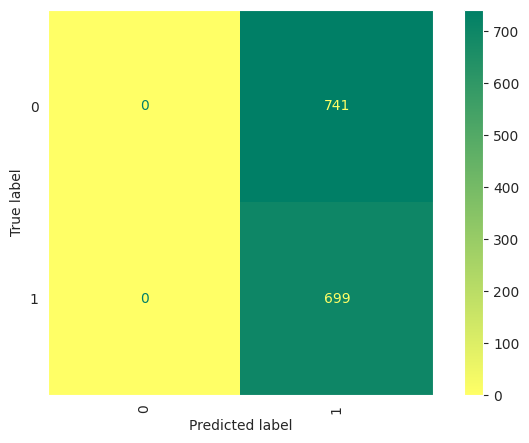

In [36]:
dados_modelo(modelo_numero)

In [37]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 3: GRU

In [38]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru'

# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas)
camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 31s 314ms/step - loss: 0.6946 - accuracy: 0.4972 - val_loss: 0.6948 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 26s 289ms/step - loss: 0.6942 - accuracy: 0.5059 - val_loss: 0.6936 - val_accuracy: 0.4854
Epoch 3/5
90/90 [==============================] - 27s 297ms/step - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6935 - val_accuracy: 0.4854
Epoch 4/5
90/90 [==============================] - 26s 293ms/step - loss: 0.6942 - accuracy: 0.4967 - val_loss: 0.6927 - val_accuracy: 0.5146
Epoch 5/5
90/90 [==============================] - 26s 296ms/step - loss: 0.6938 - accuracy: 0.4915 - val_loss: 0.6934 - val_accuracy: 0.4854
CPU times: user 1min 59s, sys: 1.36 s, total: 2min 1s
Wall time: 2min 24s


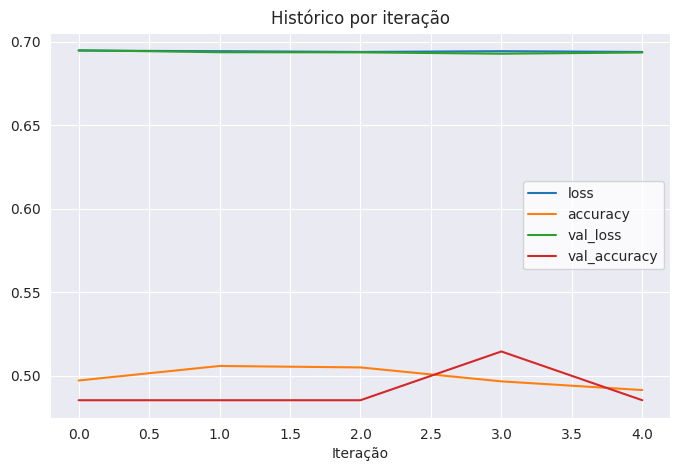

In [39]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 54ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

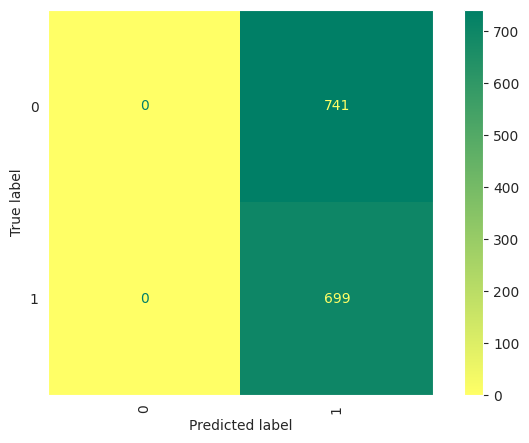

In [40]:
dados_modelo(modelo_numero)

In [41]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 4: LSTM Bidirecional

In [42]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm_bidirecional'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 40s 405ms/step - loss: 0.4516 - accuracy: 0.8229 - val_loss: 0.2303 - val_accuracy: 0.9354
Epoch 2/5
90/90 [==============================] - 35s 393ms/step - loss: 0.1502 - accuracy: 0.9592 - val_loss: 0.1577 - val_accuracy: 0.9528
Epoch 3/5
90/90 [==============================] - 42s 472ms/step - loss: 0.0551 - accuracy: 0.9889 - val_loss: 0.1645 - val_accuracy: 0.9458
Epoch 4/5
90/90 [==============================] - 34s 382ms/step - loss: 0.0237 - accuracy: 0.9964 - val_loss: 0.1883 - val_accuracy: 0.9382
Epoch 5/5
90/90 [==============================] - 34s 384ms/step - loss: 0.0185 - accuracy: 0.9965 - val_loss: 0.1886 - val_accuracy: 0.9431
CPU times: user 2min 45s, sys: 2.95 s, total: 2min 48s
Wall time: 3min 25s


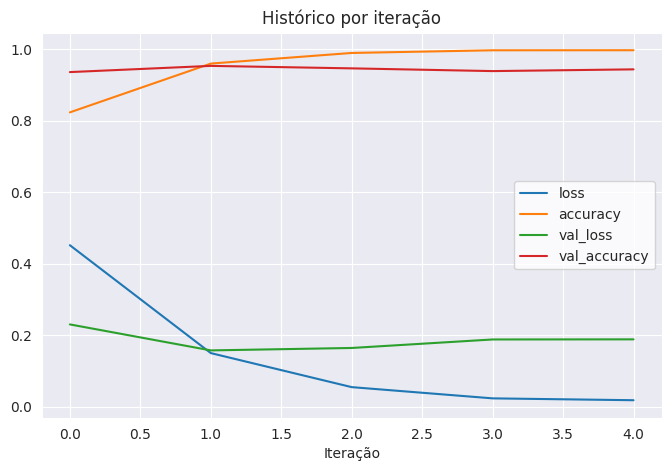

In [43]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 4s 77ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       741
           1       0.92      0.97      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



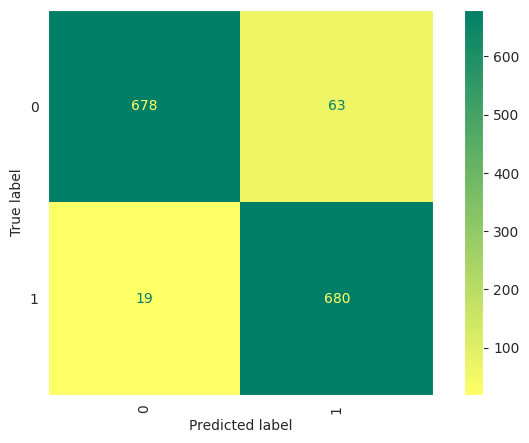

In [44]:
dados_modelo(modelo_numero)

In [45]:
relatorios[modelo_numero]

{'acuracia': 0.9430555555555555,
 'precisao': 0.944813468669482,
 'revocacao': 0.9430555555555555,
 'pontuacao-f1': 0.9430531389270941}

### Modelo 5: CNN

In [46]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 30s 236ms/step - loss: 0.1473 - accuracy: 0.9455 - val_loss: 0.1571 - val_accuracy: 0.9410
Epoch 2/5
90/90 [==============================] - 19s 209ms/step - loss: 0.0129 - accuracy: 0.9970 - val_loss: 0.1585 - val_accuracy: 0.9465
Epoch 3/5
90/90 [==============================] - 20s 225ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.1870 - val_accuracy: 0.9368
Epoch 4/5
90/90 [==============================] - 19s 209ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.1838 - val_accuracy: 0.9403
Epoch 5/5
90/90 [==============================] - 19s 205ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.1977 - val_accuracy: 0.9403
CPU times: user 1min 22s, sys: 2.03 s, total: 1min 24s
Wall time: 1min 46s


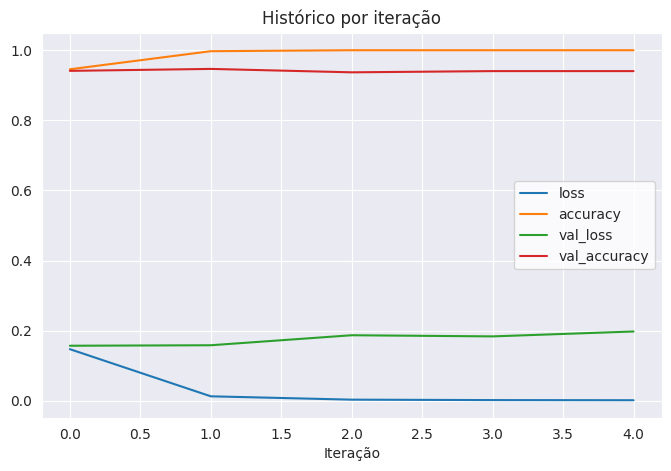

In [47]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       741
           1       0.91      0.97      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



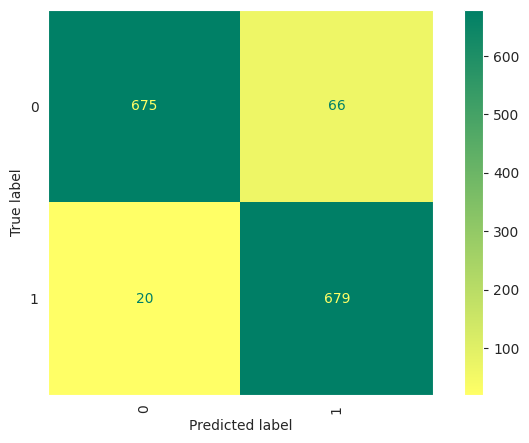

In [48]:
dados_modelo(modelo_numero)

In [49]:
relatorios[modelo_numero]

{'acuracia': 0.9402777777777778,
 'precisao': 0.9421884908180839,
 'revocacao': 0.9402777777777778,
 'pontuacao-f1': 0.9402724783113039}

### Modelo 6: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [50]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_tfhub_use'

modelos[modelo_numero] = Sequential(name=modelo_nome)

modelos[modelo_numero].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                          trainable=False,
                                          input_shape=[], # USE aceita textos de tamanho variável.
                                          dtype=ENTRADA_TIPO,
                                          name='camada_use'))

modelos[modelo_numero].add(Dense(ESPACO_SAIDA*2, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 19s 154ms/step - loss: 0.3318 - accuracy: 0.9233 - val_loss: 0.1849 - val_accuracy: 0.9333
Epoch 2/5
90/90 [==============================] - 14s 153ms/step - loss: 0.1762 - accuracy: 0.9384 - val_loss: 0.1669 - val_accuracy: 0.9347
Epoch 3/5
90/90 [==============================] - 14s 154ms/step - loss: 0.1658 - accuracy: 0.9411 - val_loss: 0.1603 - val_accuracy: 0.9354
Epoch 4/5
90/90 [==============================] - 14s 155ms/step - loss: 0.1612 - accuracy: 0.9441 - val_loss: 0.1567 - val_accuracy: 0.9389
Epoch 5/5
90/90 [==============================] - 13s 149ms/step - loss: 0.1559 - accuracy: 0.9443 - val_loss: 0.1547 - val_accuracy: 0.9389
CPU times: user 1min 31s, sys: 4.16 s, total: 1min 35s
Wall time: 2min 13s


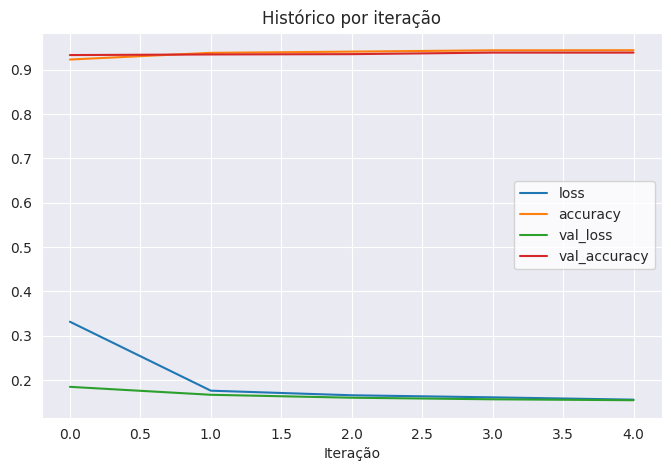

In [51]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 52ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       741
           1       0.95      0.92      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



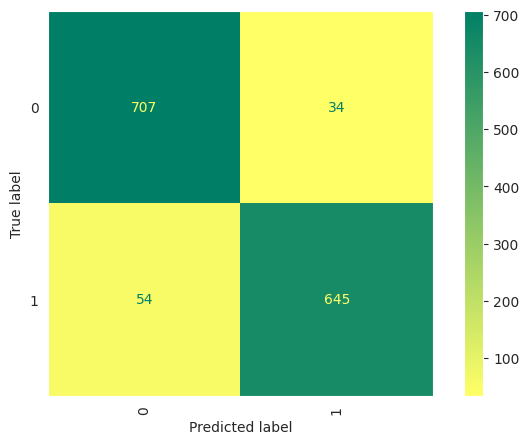

In [52]:
dados_modelo(modelo_numero)

In [53]:
relatorios[modelo_numero]

{'acuracia': 0.9388888888888889,
 'precisao': 0.9391789670336617,
 'revocacao': 0.9388888888888889,
 'pontuacao-f1': 0.9388522769511638}

## Comparar modelos

In [56]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

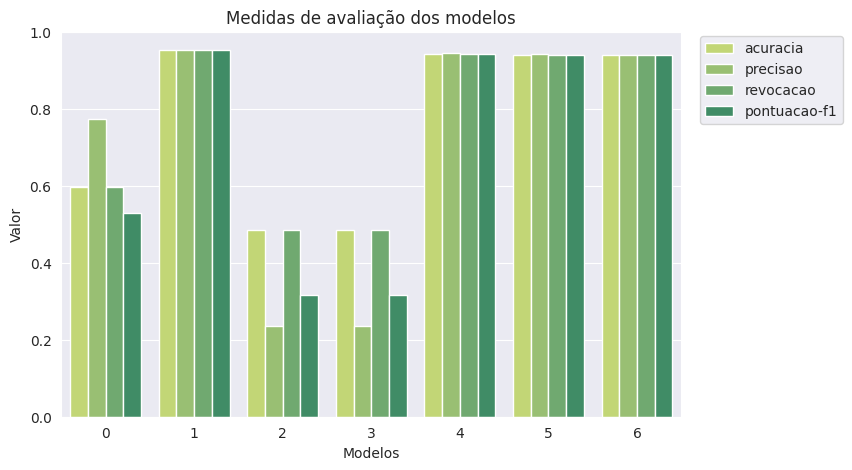

In [57]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));